In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pickle
from eval_utils import cross_boundary_correctness
import matplotlib.pyplot as plt
import pandas as pd

Global seed set to 0


In [2]:
datasets = ['MouseBoneMarrow', 'IntestinalOrganoids', 'Pancreas_with_cc', 'DentateGyrus' , 'MouseErythroid', 'Hindbrain_pons', 'HumanBoneMarrow',
            'RetinaDevelopment', 'Pancreas_without_cc',  'scNT_seq']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

In [3]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

MouseBoneMarrow
Filtered out 20300 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 358/500:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 358/500 [01:15<00:30,  4.73it/s, loss=-894, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -855.627. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2600 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
({('dividing', 'progenitors'): 0.6120774993529536, ('progenitors', 'activating'): 0.7697261711163841}, 0.6909018352346689)
IntestinalOrganoids
Filtered out 3076 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Epoch 10/500:   2%|██▉                                                                                                                                                                   | 9/500 [00:02<02:19,  3.52it/s, loss=-344, v_num=1]

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x1471e18edc60>
Traceback (most recent call last):
  File "/nfs/team283/aa16/software/miniconda3/envs/velovi_env/lib/python3.10/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


KeyboardInterrupt: 

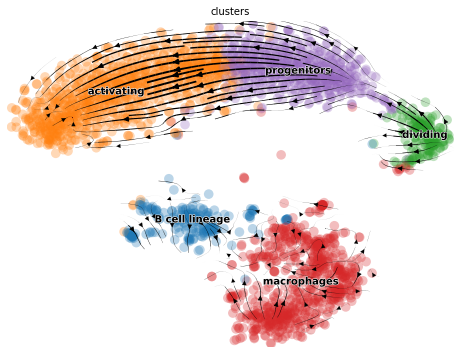

In [4]:
for dataset in datasets:
    print(dataset)
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    adata = preprocess_data(adata)
    VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(adata)
    vae.train()
    add_velovi_outputs_to_adata(adata, vae)
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata)
    scv.tl.velocity_embedding(adata)
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_VeloVI1.png')
    # Calculate performance:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    mean_score = cross_boundary_correctness(adata = adata, k_cluster = 'clusters',
                               k_velocity = 'velocity', cluster_edges = ground_truth)
    print(mean_score)
    tab = pd.read_csv(save_dir + dataset + '_scores.csv', index_col = 0)
    tab.loc['veloVI1',:] = np.array(list(mean_score[0].values()) + [mean_score[1]])
    tab.to_csv(save_dir + dataset + '_scores.csv')   